## Get Embeddings for 19hz

In [121]:
import pandas as pd
import tiktoken
from openai.embeddings_utils import get_embedding
import os
import openai

openai.apikey = os.getenv("OPENAI_API_KEY")
# embedding model parameters
embedding_model = "text-embedding-ada-002"
embedding_encoding = "cl100k_base"  # this the encoding for text-embedding-ada-002
max_tokens = 5000  # the maximum for text-embedding-ada-002 is 8191

In [99]:
df = pd.read_csv('bar_events.csv',index_col=0)
df.head()

,venue,event,date,age,price,music,performers,location
0,The Fillmore,The Avett Brothers,2018-11-08T19:30:00,18+,$39.50,"['Folk', 'Rock']",['The Avett Brothers'],NaN
1,The Fillmore,The 1975,2018-11-09T19:00:00,16+,$45.50,"['Indie', 'Pop']",['The 1975'],NaN
2,F8,INTERZONE,Tue: Feb 14,21+,free,"['darkwave', 'goth', 'EBM', 'industrial', 'wit...",['Hex Embrace'],"('1192 Folsom, San Francisco', <shapely.geomet..."
3,The Fillmore,The 1975,2018-11-09T19:00:00,16+,$45.50,"['Indie', 'Pop']",['The 1975'],NaN
4,F8,Run It Back,Wed: Feb 15 (9pm-2am),21+,free w/rsvp b4 11pm/$10,tech house,"Eve, Nickie, VlexxZ, Luongevity, JJKO","('1192 Folsom, San Francisco', <shapely.geomet..."


In [100]:
def find_venue_type(venue):
    prompt = f'Provide a short description of the following venue in SF? Utilize the venues website or online search to find the answer.' + '\n' + 'Venue: ' + venue
    return prompt


In [101]:
venue_description = {}
for index, row in df.iterrows():
    if row['venue'] not in venue_description:
        response = openai.Completion.create(
            model="text-curie-001",
            prompt=find_venue_type(row['venue']),
            temperature=0.3,
            max_tokens = 100,
        )
        response_text = response['choices'][0]['text'].strip()
        venue_description[row['venue']] = response_text
        df.loc[index, 'venue_description'] = response_text

    else:
        df.loc[index, 'venue_description'] = venue_description[row['venue']]    


,venue,event,date,age,price,music,performers,location,venue_description
0,The Fillmore,The Avett Brothers,2018-11-08T19:30:00,18+,$39.50,"['Folk', 'Rock']",['The Avett Brothers'],NaN,The Fillmore is a historic music venue in San ...
1,The Fillmore,The 1975,2018-11-09T19:00:00,16+,$45.50,"['Indie', 'Pop']",['The 1975'],NaN,The Fillmore is a historic music venue in San ...
2,F8,INTERZONE,Tue: Feb 14,21+,free,"['darkwave', 'goth', 'EBM', 'industrial', 'wit...",['Hex Embrace'],"('1192 Folsom, San Francisco', <shapely.geomet...",F8 is a nightclub in San Francisco that offers...
3,The Fillmore,The 1975,2018-11-09T19:00:00,16+,$45.50,"['Indie', 'Pop']",['The 1975'],NaN,The Fillmore is a historic music venue in San ...
4,F8,Run It Back,Wed: Feb 15 (9pm-2am),21+,free w/rsvp b4 11pm/$10,tech house,"Eve, Nickie, VlexxZ, Luongevity, JJKO","('1192 Folsom, San Francisco', <shapely.geomet...",F8 is a nightclub in San Francisco that offers...


In [118]:
df_embeddings = df.applymap(str)
encoding = tiktoken.get_encoding(embedding_encoding)
df["combined"] = (
    "Venue: " + df_embeddings.venue.str.strip() + "; Venue Description: " + df_embeddings.venue_description.str.strip() + 
    "; Event: " + df_embeddings.event.str.strip() +  "; Price: " + df_embeddings.price.str.strip() +  
    "; Music: " + df_embeddings.music.str.strip()
)

df["n_tokens"] = df.combined.apply(lambda x: len(encoding.encode(x)))

In [123]:
df["embedding"] = df.combined.apply(lambda x: get_embedding(x, engine=embedding_model))
df.to_csv("bar_events_with_embeddings.csv")

## Get Embeddings for Fun Cheap

In [187]:
fc_df = pd.read_csv('funcheap_events.csv', index_col=0)
fc_df.head()

,venue,date,age,price,location,event_description,event_name
0,Asian Art Museum,"Thursday, February 16, 2023 - 5:00 pm to 8:00 pm",13-17,"$10 for adults, $8.50 for seniors, students an...","200 Larkin Street San Francisco, CA Civic Cent...",NaN,Asian Art Museum’s $10 Thursday Nights (SF)
1,Asian Art Museum,"Thursday, February 16, 2023 - 5:00 pm to 8:00 pm",13-17,"$10 for adults, $8.50 for seniors, students an...","200 Larkin Street San Francisco, CA Civic Cent...",The Asian Art Museum is open until 8 pm on Thu...,Asian Art Museum’s $10 Thursday Nights (SF)
2,Museum of Craft and Design,"Thursday, February 16, 2023 - 5:30 pm to 9:00 pm",NaN,$8,"2569 Third Street, San Francisco, CA 94107Dogp...",The event is about making things in the dark.,“Glow in the Dark” After Hours at SF’s Museum ...
3,Del Mar,"Thursday, February 16, 2023 - 7:00 pm to 2:00 am",No cover all night,Free,"2125 Lombard St, San Francisco, CA 94123Cow Ho...",NaN,“Throwback Thursday” at Del Mar: ’90s to ’00s ...
4,Grace Cathedral,"Thursday, February 16, 2023 - 7:30 pm to 9:30 pm",General Admission,USD 25.00,"1100 California Street. San Francisco, CANob H...",NaN,“That Week with the Bachs” New Musical at Grac...


In [188]:
def find_venue_type(venue):
    prompt = f'Provide a short description of the following venue in SF? Utilize the venues website or online search to find the answer.' + '\n' + 'Venue: ' + venue
    return prompt

In [189]:
venue_description = {}
for index, row in fc_df.iterrows():
    if row['venue'] not in venue_description:
        response = openai.Completion.create(
            model="text-curie-001",
            prompt=find_venue_type(row['venue']),
            temperature=0.3,
            max_tokens = 100,
        )
        response_text = response['choices'][0]['text'].strip()
        venue_description[row['venue']] = response_text
        fc_df.loc[index, 'venue_description'] = response_text

    else:
        fc_df.loc[index, 'venue_description'] = venue_description[row['venue']]  


In [191]:
fc_df_embeddings = fc_df.applymap(str)
encoding = tiktoken.get_encoding(embedding_encoding)
fc_df["combined"] = (
    "Venue: " + fc_df_embeddings.venue.str.strip() + "; Venue Description: " + fc_df_embeddings.venue_description.str.strip() + 
    "; Event: " + fc_df_embeddings.event_name.str.strip() +  "; Event Description: " + fc_df_embeddings.event_description.str.strip() + 
    "; Price: " + fc_df_embeddings.price.str.strip()
)

fc_df["n_tokens"] = fc_df.combined.apply(lambda x: len(encoding.encode(x)))

In [194]:
fc_df.head(3)

,venue,date,age,price,location,event_description,event_name,venue_description,combined,n_tokens
0,Asian Art Museum,"Thursday, February 16, 2023 - 5:00 pm to 8:00 pm",13-17,"$10 for adults, $8.50 for seniors, students an...","200 Larkin Street San Francisco, CA Civic Cent...",NaN,Asian Art Museum’s $10 Thursday Nights (SF),The Asian Art Museum is a museum in San Franci...,Venue: Asian Art Museum; Venue Description: Th...,78
1,Asian Art Museum,"Thursday, February 16, 2023 - 5:00 pm to 8:00 pm",13-17,"$10 for adults, $8.50 for seniors, students an...","200 Larkin Street San Francisco, CA Civic Cent...",The Asian Art Museum is open until 8 pm on Thu...,Asian Art Museum’s $10 Thursday Nights (SF),The Asian Art Museum is a museum in San Franci...,Venue: Asian Art Museum; Venue Description: Th...,173
2,Museum of Craft and Design,"Thursday, February 16, 2023 - 5:30 pm to 9:00 pm",NaN,$8,"2569 Third Street, San Francisco, CA 94107Dogp...",The event is about making things in the dark.,“Glow in the Dark” After Hours at SF’s Museum ...,The Museum of Craft and Design is a museum in ...,Venue: Museum of Craft and Design; Venue Descr...,95


In [195]:
fc_df["embedding"] = fc_df.combined.apply(lambda x: get_embedding(x, engine=embedding_model))
fc_df.to_csv("funcheap_events_with_embeddings.csv")

## Cluster Data

In [2]:
import numpy as np
import pandas as pd

data = pd.read_csv('bar_events_with_embeddings.csv',index_col=0)
data2 = pd.read_csv("funcheap_events_with_embeddings.csv",index_col=0)

# concatenate data frames vertically
concatenated_data = pd.concat([data, data2], axis=0)

# convert "embedding" column from string to numpy array
concatenated_data["embedding"] = concatenated_data.embedding.apply(eval).apply(np.array)

# extract the matrix
matrix = np.vstack(concatenated_data.embedding.values)

print(matrix.shape)


(326, 1536)


In [4]:
import wandb

original_cols = concatenated_data.columns[1:-1].tolist()
embedding_cols = ['emb_'+str(idx) for idx in range(len(matrix[0]))]
table_cols = original_cols + embedding_cols

with wandb.init(project='openai_embeddings'):
    table = wandb.Table(columns=table_cols)
    for i, row in enumerate(concatenated_data.to_dict(orient="records")):
        original_data = [row[col_name] for col_name in original_cols]
        embedding_data = matrix[i].tolist()
        table.add_data(*(original_data + embedding_data))
    wandb.log({'openai_embedding_table': table})

In [205]:
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans


# Load the data into a pandas dataframe

# Convert the dataframe to a numpy array
# Try different numbers of clusters
for n_clusters in range(2, 40):
    # Train a KMeans model with the specified number of clusters
    kmeans = KMeans(n_clusters=n_clusters)
    kmeans.fit(matrix)
    
    # Calculate the silhouette score for this clustering solution
    silhouette_avg = silhouette_score(matrix, kmeans.labels_)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

For n_clusters = 2 The average silhouette_score is : 0.11801302702509256
For n_clusters = 3 The average silhouette_score is : 0.13763940692248847
For n_clusters = 4 The average silhouette_score is : 0.14889946256953043
For n_clusters = 5 The average silhouette_score is : 0.16398130417439516
For n_clusters = 6 The average silhouette_score is : 0.17899269131948287
For n_clusters = 7 The average silhouette_score is : 0.19222903082561882
For n_clusters = 8 The average silhouette_score is : 0.199129393833457
For n_clusters = 9 The average silhouette_score is : 0.19503583610909966
For n_clusters = 10 The average silhouette_score is : 0.21322910972536435
For n_clusters = 11 The average silhouette_score is : 0.214824775325218
For n_clusters = 12 The average silhouette_score is : 0.2482175588258071
For n_clusters = 13 The average silhouette_score is : 0.2571906277840213
For n_clusters = 14 The average silhouette_score is : 0.26469225775025995
For n_clusters = 15 The average silhouette_score is 

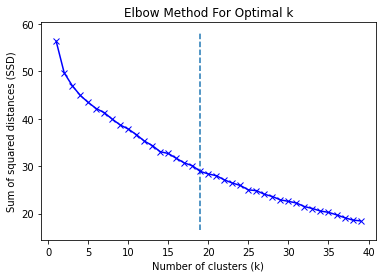

The knee point is at k = 19


In [206]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from kneed import KneeLocator

# load the data

# calculate the sum of squared distances for different values of k
ssd = []
K = range(1, 40)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(matrix)
    ssd.append(kmeans.inertia_)

# find the knee point
kl = KneeLocator(K, ssd, curve='convex', direction='decreasing')
knee = kl.knee

# plot the results with the knee point marked
plt.plot(K, ssd, 'bx-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Sum of squared distances (SSD)')
plt.title('Elbow Method For Optimal k')
plt.vlines(knee, plt.ylim()[0], plt.ylim()[1], linestyles='dashed')
plt.show()

# print the knee point
print("The knee point is at k =", knee)



In [226]:
from sklearn.cluster import KMeans

n_clusters = 15

kmeans = KMeans(n_clusters=n_clusters, init="k-means++", random_state=42)
kmeans.fit(matrix)
labels = kmeans.labels_
concatenated_data["Cluster"] = labels

In [227]:
concatenated_data['Cluster'].value_counts()

13    51
0     48
4     30
14    29
12    25
1     21
11    20
2     17
9     14
5     14
3     12
7     12
10    11
6     11
8     11
Name: Cluster, dtype: int64

Text(0.5, 1.0, 'Clusters identified visualized in language 2d using t-SNE')

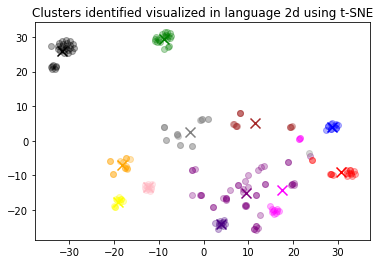

In [232]:
from sklearn.manifold import TSNE
import matplotlib
import matplotlib.pyplot as plt

tsne = TSNE(n_components=2, perplexity=15, random_state=42, init="random", learning_rate=200)
vis_dims2 = tsne.fit_transform(matrix)

x = [x for x, y in vis_dims2]
y = [y for x, y in vis_dims2]

for category, color in enumerate(["purple", "green", "red", "blue", "black", "orange", "yellow", "brown", "lightpink", "magenta", "indigo", "grey"]):
    xs = np.array(x)[concatenated_data.Cluster == category]
    ys = np.array(y)[concatenated_data.Cluster == category]
    plt.scatter(xs, ys, color=color, alpha=0.3)

    avg_x = xs.mean()
    avg_y = ys.mean()

    plt.scatter(avg_x, avg_y, marker="x", color=color, s=100)
plt.title("Clusters identified visualized in language 2d using t-SNE")

In [233]:
from sklearn.decomposition import PCA
pca = PCA(n_components=3)
vis_dims = pca.fit_transform(matrix)
concatenated_data["embed_vis"] = vis_dims.tolist()
categories = sorted(concatenated_data["Cluster"].unique())

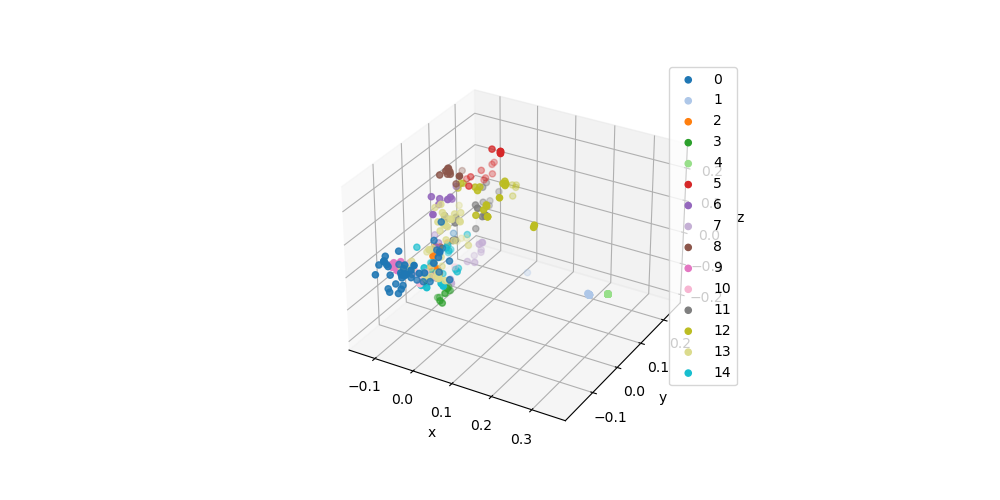

Unhandled message type set_device_pixel_ratio. {'device_pixel_ratio': 2, 'type': 'set_device_pixel_ratio'}


In [235]:
%matplotlib widget
import matplotlib.pyplot as plt
import numpy as np

fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(projection='3d')
cmap = plt.get_cmap("tab20")

# Plot each sample category individually such that we can set label name.
for i, cat in enumerate(categories):
    sub_matrix = np.array(concatenated_data[concatenated_data["Cluster"] == cat]["embed_vis"].to_list())
    x=sub_matrix[:, 0]
    y=sub_matrix[:, 1]
    z=sub_matrix[:, 2]
    colors = [cmap(i/len(categories))] * len(sub_matrix)
    ax.scatter(x, y, zs=z, zdir='z', c=colors, label=cat)

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.legend(bbox_to_anchor=(1.1, 1))

In [236]:
data.columns

Index(['venue', 'event', 'date', 'age', 'price', 'music', 'performers',
       'location', 'venue_description', 'combined', 'n_tokens', 'embedding'],
      dtype='object')

In [240]:
rev_per_cluster = 5

for i in range(15):
    print(f"Cluster {i} Theme:", end=" ")

    venues = "\n".join(
        concatenated_data[concatenated_data.Cluster == i]
        .combined.str.replace("Venue: ", "")
        .str.replace("Venue Description: ", ":  ")
        .str.replace("Event: ", ":  ")
        .str.replace("Price: ", ":  ")
        .str.replace("Music: ", ":  ")
        .str.replace("Event Description: ", ": ")
        .sample(rev_per_cluster, random_state=42)
        .values
    )
    response = openai.Completion.create(
        engine="text-davinci-003",
        prompt=f'What do the following venues have in common?\n\nVenue Descriptions:\n"""\n{venues}\n"""\n\nTheme:',
        temperature=0,
        max_tokens=64,
        top_p=1,
        frequency_penalty=0,
        presence_penalty=0,
    )
    print(response["choices"][0]["text"].replace("\n", ""))

Cluster 0 Theme:  All of the venues are located in San Francisco.
Cluster 1 Theme:  The Fillmore is a historic music venue in San Francisco hosting the 1975 with a ticket price of $45.50 and playing Indie and Pop music.
Cluster 2 Theme: The venues all have the same location (the Regency Ballroom in San Francisco) and feature live music and comedy performances. They also all have similar ticket prices ($15-$40) and feature similar genres of music (hip-hop, top 40, house, EDM, future bass, trap).
Cluster 3 Theme: The common theme among these venues is that they are all located in San Francisco, California. They all feature a stage, sound and lighting system, and a large dance floor. They all host a variety of music events, including concerts, DJ events, and private events.
Cluster 4 Theme: The venues all have the same description (The Fillmore is a historic music venue in San Francisco.), the same artist (The Avett Brothers), the same ticket price ($39.50), and the same genres of music (